# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [2]:
def sentence_generator(filename):
    with open(filename, 'r') as f:
        for line in f:
            yield line.lower().split() 

In [3]:
words = [w for sentence in sentence_generator('text8') for w in sentence]

In [4]:
vocab_size = 20000
unique_words = Counter(words)
most_common = unique_words.most_common(vocab_size - 3)
vocab = [w[0] for w in most_common]
vocab += ['<UNK>', '<START>', '<END>']
word2ind = dict(zip(vocab, range(vocab_size)))
ind2word = {i:w for w, i in word2ind.items()}

In [5]:
def encode_as_indices(word_list, word2ind):
    unk = word2ind['<UNK>']
    return [word2ind[w] if w in word2ind else unk
            for w in ['<START>'] + word_list + ['<END>']]

def decode_indices(ind_list, ind2word):
    return [ind2word[i] for i in ind_list]

In [6]:
encoded_text = encode_as_indices(words, word2ind)

In [7]:
class CBOWBatcher:
    def __init__(self, sentence, window_size, batch_size):
        self.sentence = sentence
        self.window_size = window_size
        self.batch_size = batch_size
        self.center_positions = list(range(self.window_size, 
                                      len(self.sentence) - self.window_size))
        self.centers = len(self.center_positions)
        
    def __iter__(self):
        for batch in range(0, self.centers, self.batch_size):
            batch_positions = self.center_positions[batch:
                                               min(batch + self.batch_size, self.centers)]
            yield torch.tensor([self.sentence[pos - self.window_size:pos] + 
                                self.sentence[pos+1:pos + self.window_size + 1] 
                                for pos in batch_positions]), \
            torch.tensor([self.sentence[pos] for pos in batch_positions])
        np.random.shuffle(self.center_positions)
            
    def __len__(self):
        total = len(self.sentence) - 2*self.window_size
        return total // self.batch_size + 1

In [8]:
class Word2VecCBOWNet(nn.Module):
    def __init__(self, input_size, embed_dim, window_size=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = embed_dim
        self.window_size = window_size
        class MeanLayer(nn.Module):
            def __init__(self):
                super().__init__()
            
            def forward(self, x):
                return x.view(-1, 2*window_size, embed_dim).mean(dim=1)
        
        self.input_W = nn.Embedding(input_size, self.hidden_size)
        self.output_W = nn.Linear(self.hidden_size, input_size) 
        nn.init.kaiming_normal_(self.input_W.weight)
        nn.init.kaiming_normal_(self.output_W.weight)
        self.mean = MeanLayer()
        self.layers = [self.input_W, self.mean, self.output_W]
        self.loss_layer = nn.CrossEntropyLoss()

    def forward(self, x, y):
        if self.cuda:
            x = x.cuda()
            y = y.cuda()
        for layer in self.layers:
            x = layer(x)
        return self.loss_layer(x, y)
    
    def word_vectors(self):
        return 0.5*(self.input_W.weight.data + model.output_W.weight.data).cpu()

In [9]:
class Trainer():
    def __init__(self, model, train_data, dev_data, batcher, log_path='tensorboard_log'):
        self.model = model
        self.train_data = train_data
        self.dev_data = dev_data        
        self.batcher = batcher
        self.train_loss  = []
        self.dev_loss = []
        self.cuda = (torch.cuda.device_count() > 0)
        self.writer = SummaryWriter(log_path)
        if self.cuda:
            self.model = self.model.cuda()
        
    def run_epoch(self, epoch):
        print(f'epoch {epoch}')
        evals = len(self.train_batcher) // self.eval_every
        for window, (X, y) in enumerate(self.train_batcher):
            self.model.train(True)
            loss = self.model.forward(X, y)
            self.model.zero_grad()
            loss.backward()
            self.optimizer.step()
            if window % self.eval_every == 0:
                self.train_loss.append(loss.item())
                dev_loss = self.evaluate_loss()
                self.dev_loss.append(dev_loss)
                step = window + len(self.train_batcher)*epoch
                self.writer.add_scalar('train_loss', loss.item(), global_step=step)
                self.writer.add_scalar('dev_loss', dev_loss, global_step=step)
                print(self.dev_loss[-1], f'step {window // self.eval_every}/{evals}')

    def train(self, epochs=1, checkpoint_name='current_model', load=None,
              batch_size=8, lr=0.001, eval_every=1000):
        self.eval_every = eval_every
        self.train_batcher = self.batcher(self.train_data, 
                                          self.model.window_size, batch_size)
        self.dev_batcher = self.batcher(self.dev_data, 
                                        self.model.window_size, batch_size)
        self.optimizer = opt.Adam(self.model.parameters(), lr=lr)
        if load is not None:
            checkpoint = torch.load(load)
            self.model.load_state_dict(checkpoint['model'])
            if self.cuda:
                self.model = self.model.cuda()
            self.optimizer.load_state_dict(checkpoint['opt'])
        for e in range(epochs):
            self.run_epoch(e)
            torch.save({'model': self.model.state_dict(),
                        'opt': self.optimizer.state_dict()}, checkpoint_name)
            
    def evaluate_loss(self):
        self.model.train(False)
        total_loss = 0.0
        total_windows = 0
        for X, y in self.dev_batcher:
            loss = self.model.forward(torch.tensor(X), torch.tensor(y))
            total_loss += X.shape[0]*loss.item()
            total_windows += X.shape[0]
        return total_loss / total_windows

In [10]:
len(words)

17005207

In [11]:
embeddings_dim = 32
window_size = 2
dev_size = int(round(len(words)*0.1))
train_data = encode_as_indices(words[:-dev_size], word2ind)
dev_data = encode_as_indices(words[-dev_size:], word2ind)
model = Word2VecCBOWNet(vocab_size, embeddings_dim, window_size)

In [12]:
trainer = Trainer(model, train_data, dev_data, CBOWBatcher)

In [13]:
%%time
trainer.train(10, batch_size=10000, lr=0.001, eval_every=100)

epoch 0


/home/gracheva/.local/share/virtualenvs/notebooks-daHk8xui/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


9.937638724707714 step 0/15
9.548489575678458 step 1/15
8.529958825108869 step 2/15
7.373547640296176 step 3/15
6.964068412435862 step 4/15
6.812811407365072 step 5/15
6.721895350630291 step 6/15
6.643435977585588 step 7/15
6.587833058776389 step 8/15
6.535378184105386 step 9/15
6.491993824994456 step 10/15
6.45488767517616 step 11/15
6.421165128972716 step 12/15
6.38437510165948 step 13/15
6.3528593008239405 step 14/15
6.322967051899464 step 15/15
epoch 1
6.314299181039186 step 0/15
6.288417778208763 step 1/15
6.26406597773747 step 2/15
6.240840332276635 step 3/15
6.218647089464547 step 4/15
6.197383356025072 step 5/15
6.17686724813906 step 6/15
6.157519149567613 step 7/15
6.138489727363719 step 8/15
6.120595553715016 step 9/15
6.103322013796826 step 10/15
6.086853857676632 step 11/15
6.0706763543956175 step 12/15
6.055157163629203 step 13/15
6.040159004603944 step 14/15
6.0257464708128055 step 15/15
epoch 2
6.021198937625124 step 0/15
6.007711463598148 step 1/15
5.994971890292634 ste

Время обучения - 1.5 часа (9 минут на эпоху)  
График лосса; видно, что сходимость постепенно замедляется:

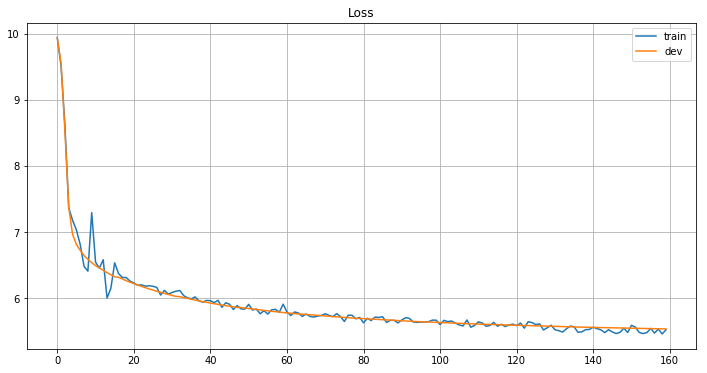

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(trainer.train_loss)), trainer.train_loss, label='train')
plt.plot(np.arange(len(trainer.dev_loss)), trainer.dev_loss, label='dev')
plt.legend()
plt.grid()
t = plt.title('Loss')

Визуализируем вектора в двумерном прострранстве с помощью PCA и рассмотрим поближе выделенную область:

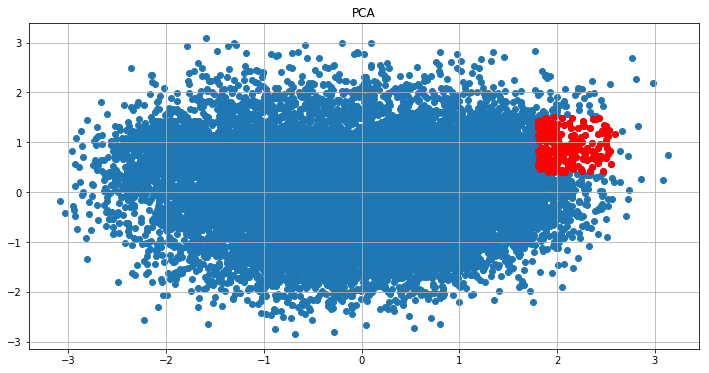

In [62]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(trainer.model.word_vectors()).T

plt.figure(figsize=(12, 6))
plt.scatter(principal_components[0], principal_components[1])
xl, xr, yl, yr = 1.8, 2.6, 0.4, 1.5
condition = np.all([principal_components[0] > xl, 
                    principal_components[0] < xr, 
                    principal_components[1] > yl, 
                    principal_components[1] < yr], axis=0)
x = principal_components[0][condition]
y = principal_components[1][condition]
plt.scatter(x, y, color='r')
plt.grid()
t = plt.title('PCA')

Видим, что в ней собрана life science и computer science терминология, однако более точные кластеры не просматриваются:

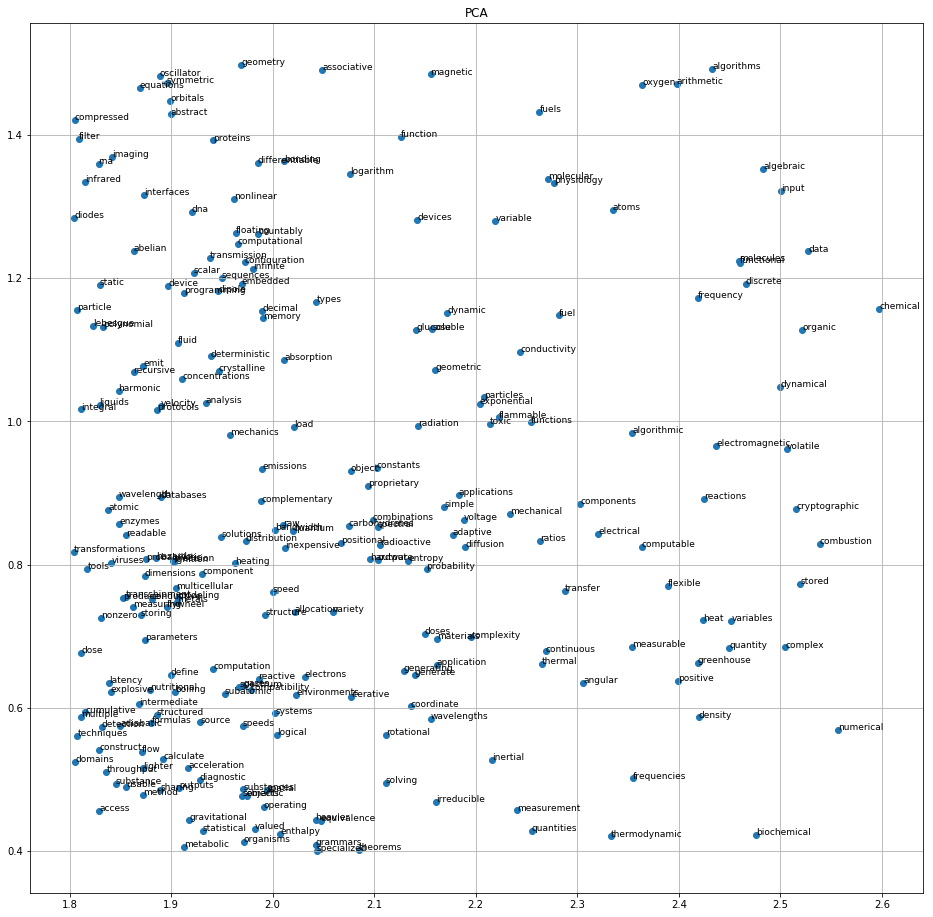

In [63]:
plt.figure(figsize=(16, 16))
plt.scatter(x, y)
plt.grid()
for x0, y0, ind in zip(x, y, np.arange(vocab_size)[condition]):
    plt.text(x0, y0, ind2word[ind], fontsize=9)
t = plt.title('PCA')

Сделаем то же самое с T-SNE:

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model.word_vectors()).T

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.022s...
[t-SNE] Computed neighbors for 20000 samples in 21.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

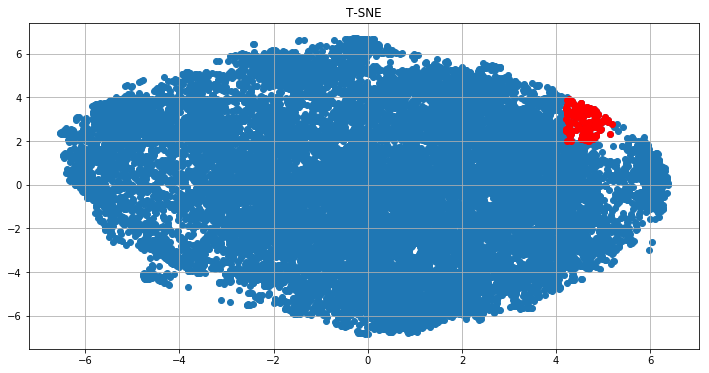

In [38]:
plt.figure(figsize=(12, 6))
plt.scatter(tsne_results[0], tsne_results[1])
xl, xr, yl, yr = 4.2, 5.2, 2, 4
condition = np.all([tsne_results[0] > xl,
                    tsne_results[0] < xr, 
                    tsne_results[1] > yl, 
                    tsne_results[1] < yr], axis=0)
x = tsne_results[0][condition]
y = tsne_results[1][condition]
plt.scatter(x, y, color='r')
plt.grid()
t = plt.title('T-SNE')

В выделенной области оказались слова, относящиеся к идеологиям, и тут лучше видны специфические отношения, например atheists близко к agnostics, а marksist к leninist.  
Следовательно, визуализация с t-SNE более наглядная, но менее эффективная (работала дольше по времени)

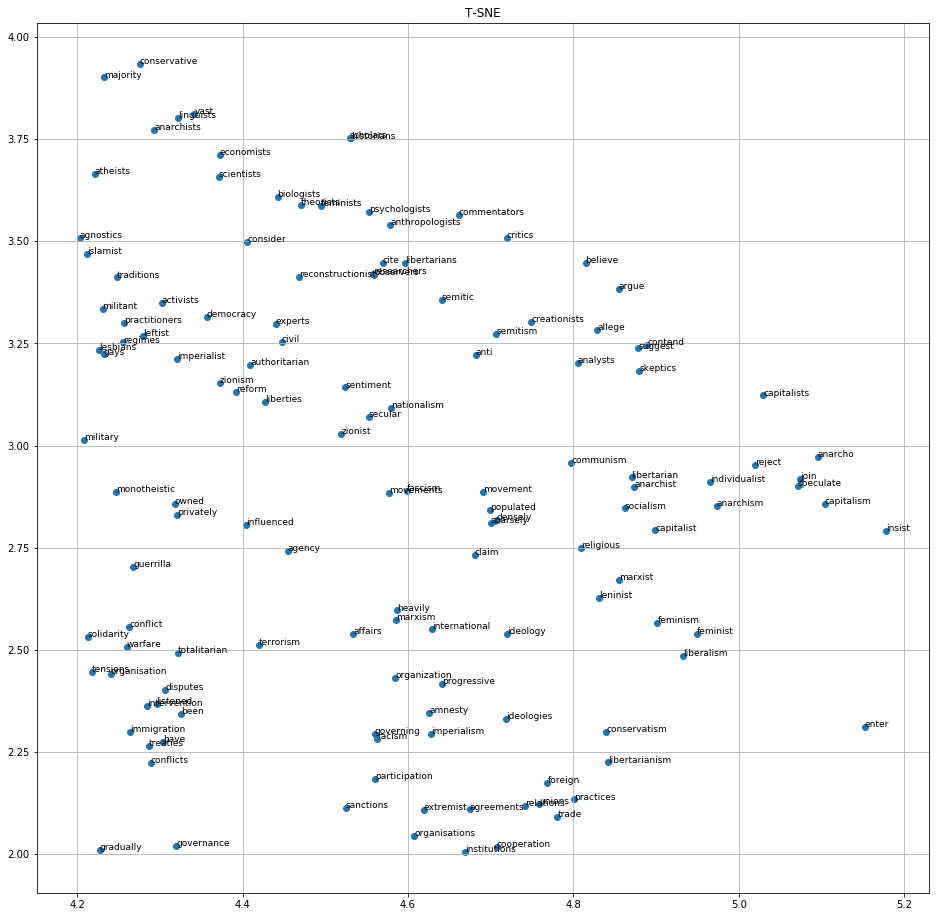

In [39]:
plt.figure(figsize=(16, 16))
plt.scatter(x, y)
plt.grid()
for x0, y0, ind in zip(x, y, np.arange(vocab_size)[condition]):
    plt.text(x0, y0, ind2word[ind], fontsize=9)
t = plt.title('T-SNE')

Возьмём набор слов из предыдущего задания и получим их визуализацию. Страны хорошо сгруппировались в один кластер:

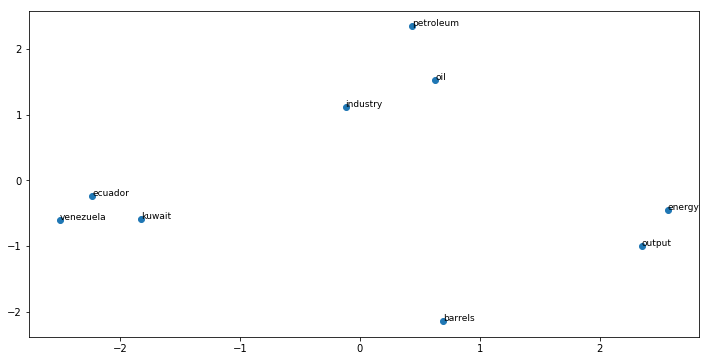

In [24]:
words_to_plot = ['barrels', 'ecuador', 'energy', 'industry', 
         'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
wordvec_to_plot = np.array([word2vec.get_vector(word) 
                           for word in words_to_plot])
pca = PCA(n_components=2)
test_principal_components = pca.fit_transform(wordvec_to_plot).T
plt.figure(figsize=(12, 6))
plt.scatter(test_principal_components[0], test_principal_components[1])
for i in range(test_principal_components.shape[1]):
    plt.text(test_principal_components[0][i], test_principal_components[1][i], 
             words_to_plot[i], fontsize=9)

Создадим класс для удобного отображения слов в векторное пространство, поиска ближайших соседей и т.д.:

In [241]:
class Word2Vec:
    def __init__(self, word_vectors, word2ind, ind2word):
        self.word_vectors = np.array(word_vectors)
        self.word2ind = word2ind
        self.ind2word = ind2word
        self.cosine_similarities = cosine_similarity(self.word_vectors)
        
    def get_vector(self, word):
        if word not in word2ind:
            return 
        return self.word_vectors[self.word2ind[word]]
    
    def k_neighbours(self, word, k=5):
        if word not in word2ind:
            print('out of vocabulary:', word)
        ans = []
        for ind in self.cosine_similarities[word2ind[word]].argsort()[-k-1:-1][::-1]:
            ans.append(ind2word[ind])
        return ans
    
    def nearest_word_to_vector(self, vector):
        dist = cosine_similarity(self.word_vectors, vector.reshape(1, -1)).reshape(-1)
        return self.ind2word[np.argmax(dist)]
    
    def distance(self, x, y):
        if x in self.word2ind and y in self.word2ind:
            ind_x = self.word2ind[x]
            ind_y = self.word2ind[y]
        else:
            print('out of vocabulary')
            return
        return self.cosine_similarities[ind_x][ind_y]

In [242]:
word2vec = Word2Vec(trainer.model.word_vectors(), word2ind, ind2word)

Примеры с ближайшими соседями:

In [223]:
print(word2vec.k_neighbours('france'))
print(word2vec.k_neighbours('mother'))
print(word2vec.k_neighbours('writer'))
print(word2vec.k_neighbours('mathematics'))

['italy', 'spain', 'russia', 'germany', 'poland']
['father', 'wife', 'daughter', 'husband', 'grandfather']
['poet', 'novelist', 'journalist', 'critic', 'artist']
['physics', 'linguistics', 'astronomy', 'evolutionary', 'logic']


И, наконец, примеры с аналогиями:

In [259]:
expected_mother = word2vec.nearest_word_to_vector(word2vec.get_vector(
    'sister') + word2vec.get_vector('father') - word2vec.get_vector('brother'))
expected_father = word2vec.nearest_word_to_vector(word2vec.get_vector(
    'grandfather') + word2vec.get_vector('mother') - word2vec.get_vector('grandmother'))
expected_she = word2vec.nearest_word_to_vector(word2vec.get_vector(
    'bride') + word2vec.get_vector('he') - word2vec.get_vector('groom'))
expected_princess = word2vec.nearest_word_to_vector(word2vec.get_vector(
    'queen') + word2vec.get_vector('prince') - word2vec.get_vector('king'))
expected_daughter = word2vec.nearest_word_to_vector(word2vec.get_vector(
    'princess') + word2vec.get_vector('son') - word2vec.get_vector('prince'))

In [261]:
print(expected_mother)
print(expected_father)
print(expected_she)
print(expected_princess)
print(expected_daughter)

mother
father
she
princess
daughter
